# Recommendations with IBM

In this notebook, you will be putting your recommendation skills to use on real data from the IBM Watson Studio platform. 


You may either submit your notebook through the workspace here, or you may work from your local machine and submit through the next page.  Either way assure that your code passes the project [RUBRIC](https://review.udacity.com/#!/rubrics/3325/view).  **Please save regularly.**

By following the table of contents, you will build out a number of different methods for making recommendations that can be used for different situations. 


## Table of Contents

I. [Exploratory Data Analysis](#Exploratory-Data-Analysis)<br>
II. [Rank Based Recommendations](#Rank)<br>
III. [User-User Based Collaborative Filtering](#User-User)<br>
IV. [Content Based Recommendations (EXTRA - NOT REQUIRED)](#Content-Recs)<br>
V. [Matrix Factorization](#Matrix-Fact)<br>
VI. [Extras & Concluding](#conclusions)

At the end of the notebook, you will find directions for how to submit your work.  Let's get started by importing the necessary libraries and reading in the data.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import project_tests as t
import pickle

%matplotlib inline

df = pd.read_csv('data/user-item-interactions.csv')
df_content = pd.read_csv('data/articles_community.csv')
del df['Unnamed: 0']
del df_content['Unnamed: 0']

# Show df to get an idea of the data
df.head()

,article_id,title,email
0,1430.0,"using pixiedust for fast, flexible, and easier...",ef5f11f77ba020cd36e1105a00ab868bbdbf7fe7
1,1314.0,healthcare python streaming application demo,083cbdfa93c8444beaa4c5f5e0f5f9198e4f9e0b
2,1429.0,use deep learning for image classification,b96a4f2e92d8572034b1e9b28f9ac673765cd074
3,1338.0,ml optimization using cognitive assistant,06485706b34a5c9bf2a0ecdac41daf7e7654ceb7
4,1276.0,deploy your python model as a restful api,f01220c46fc92c6e6b161b1849de11faacd7ccb2


In [2]:
# Show df_content to get an idea of the data
df_content.head()

,doc_body,doc_description,doc_full_name,doc_status,article_id
0,Skip navigation Sign in SearchLoading...\r\n\r...,Detect bad readings in real time using Python ...,Detect Malfunctioning IoT Sensors with Streami...,Live,0
1,No Free Hunch Navigation * kaggle.com\r\n\r\n ...,"See the forest, see the trees. Here lies the c...",Communicating data science: A guide to present...,Live,1
2,☰ * Login\r\n * Sign Up\r\n\r\n * Learning Pat...,Here’s this week’s news in Data Science and Bi...,"This Week in Data Science (April 18, 2017)",Live,2
3,"DATALAYER: HIGH THROUGHPUT, LOW LATENCY AT SCA...",Learn how distributed DBs solve the problem of...,DataLayer Conference: Boost the performance of...,Live,3
4,Skip navigation Sign in SearchLoading...\r\n\r...,This video demonstrates the power of IBM DataS...,Analyze NY Restaurant data using Spark in DSX,Live,4


### <a class="anchor" id="Exploratory-Data-Analysis">Part I : Exploratory Data Analysis</a>

Use the dictionary and cells below to provide some insight into the descriptive statistics of the data.

`1.` What is the distribution of how many articles a user interacts with in the dataset?  Provide a visual and descriptive statistics to assist with giving a look at the number of times each user interacts with an article.  

In [3]:
df.groupby('email')['article_id']

In [4]:
Explore_data = df.groupby('email')['article_id'].count()
Explore_data.describe()

count    5148.000000
mean        8.930847
std        16.802267
min         1.000000
25%         1.000000
50%         3.000000
75%         9.000000
max       364.000000
Name: article_id, dtype: float64

In [5]:
Explore_data[:5]

email
0000b6387a0366322d7fbfc6434af145adf7fed1    13
001055fc0bb67f71e8fa17002342b256a30254cd     4
00148e4911c7e04eeff8def7bbbdaf1c59c2c621     3
001a852ecbd6cc12ab77a785efa137b2646505fe     6
001fc95b90da5c3cb12c501d201a915e4f093290     2
Name: article_id, dtype: int64

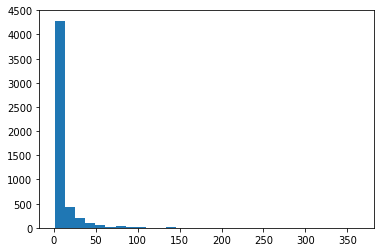

In [6]:
# interactions of users with articles (visual)
# Xlable = Interactions
# Ylable = Users
plt.hist(Explore_data, 30);

In [7]:
# Fill in the median and maximum number of user_article interactios below

median_val = 3# 50% of individuals interact with ____ number of articles or fewer.
max_views_by_user = 364 # The maximum number of user-article interactions by any 1 user is ______.

`2.` Explore and remove duplicate articles from the **df_content** dataframe.  

In [8]:
# Find and explore duplicate articles
df_content.duplicated("article_id").sum()

5

In [9]:
# Remove any rows that have the same article_id - only keep the first
df_content = df_content.drop_duplicates(subset='article_id', keep='first')

In [10]:
df_content.duplicated("article_id").sum()

0

`3.` Use the cells below to find:

**a.** The number of unique articles that have an interaction with a user.  
**b.** The number of unique articles in the dataset (whether they have any interactions or not).<br>
**c.** The number of unique users in the dataset. (excluding null values) <br>
**d.** The number of user-article interactions in the dataset.

In [11]:
# a. Number of unique articles that have an interaction with a user
unique_articles = len(df['article_id'].unique())
print(f"Number of unique articles with user interactions: {unique_articles}")

# b. Number of unique articles in the dataset
total_articles = len(df_content['article_id'].unique())
print(f"Total number of unique articles in the dataset: {total_articles}")

# c. Number of unique users in the dataset
unique_users = len(df['email'].unique())
print(f"Number of unique users: {unique_users}")

# d. Number of user-article interactions in the dataset
user_article_interactions = len(df)
print(f"Total number of user-article interactions: {user_article_interactions}")


Number of unique articles with user interactions: 714
Total number of unique articles in the dataset: 1051
Number of unique users: 5149
Total number of user-article interactions: 45993


In [12]:
unique_articles = 714 # The number of unique articles that have at least one interaction
total_articles = 1051 # The number of unique articles on the IBM platform
unique_users = 5149 # The number of unique users
user_article_interactions = 45993 # The number of user-article interactions

`4.` Use the cells below to find the most viewed **article_id**, as well as how often it was viewed.  After talking to the company leaders, the `email_mapper` function was deemed a reasonable way to map users to ids.  There were a small number of null values, and it was found that all of these null values likely belonged to a single user (which is how they are stored using the function below).

In [13]:
most_viewed_article_id = df.groupby('article_id')['email'].count().sort_values(ascending=False)
most_viewed_article_id.head()

article_id
1429.0    937
1330.0    927
1431.0    671
1427.0    643
1364.0    627
Name: email, dtype: int64

In [14]:
most_viewed_article_id = '1429.0'# The most viewed article in the dataset as a string with one value following the decimal 
max_views = 937# The most viewed article in the dataset was viewed how many times?

In [15]:
## No need to change the code here - this will be helpful for later parts of the notebook
# Run this cell to map the user email to a user_id column and remove the email column

def email_mapper():
    coded_dict = dict()
    cter = 1
    email_encoded = []
    
    for val in df['email']:
        if val not in coded_dict:
            coded_dict[val] = cter
            cter+=1
        
        email_encoded.append(coded_dict[val])
    return email_encoded

email_encoded = email_mapper()
del df['email']
df['user_id'] = email_encoded

# show header
df.head()

,article_id,title,user_id
0,1430.0,"using pixiedust for fast, flexible, and easier...",1
1,1314.0,healthcare python streaming application demo,2
2,1429.0,use deep learning for image classification,3
3,1338.0,ml optimization using cognitive assistant,4
4,1276.0,deploy your python model as a restful api,5


In [16]:
## If you stored all your results in the variable names above, 
## you shouldn't need to change anything in this cell

sol_1_dict = {
    '`50% of individuals have _____ or fewer interactions.`': median_val,
    '`The total number of user-article interactions in the dataset is ______.`': user_article_interactions,
    '`The maximum number of user-article interactions by any 1 user is ______.`': max_views_by_user,
    '`The most viewed article in the dataset was viewed _____ times.`': max_views,
    '`The article_id of the most viewed article is ______.`': most_viewed_article_id,
    '`The number of unique articles that have at least 1 rating ______.`': unique_articles,
    '`The number of unique users in the dataset is ______`': unique_users,
    '`The number of unique articles on the IBM platform`': total_articles
}

# Test your dictionary against the solution
t.sol_1_test(sol_1_dict)

Oops! It looks like the value associated with: `The number of unique users in the dataset is ______` wasn't right. Try again.  It might just be the datatype.  All of the values should be ints except the article_id should be a string.  Let each row be considered a separate user-article interaction.  If a user interacts with an article 3 times, these are considered 3 separate interactions.

  Notice you may also find the number of unique users as 5149 if you count the null user.  However, this is hard to catch without mapping first!


### <a class="anchor" id="Rank">Part II: Rank-Based Recommendations</a>

Unlike in the earlier lessons, we don't actually have ratings for whether a user liked an article or not.  We only know that a user has interacted with an article.  In these cases, the popularity of an article can really only be based on how often an article was interacted with.

`1.` Fill in the function below to return the **n** top articles ordered with most interactions as the top. Test your function using the tests below.

In [17]:
def get_top_articles(n):
    '''
    INPUT:
    n - (int) the number of top articles to return
    
    OUTPUT:
    top_articles - (list) A list of the top 'n' article titles
    '''
    global df  # Access the global 'df' variable
    
    # Counting the occurrences of each article title in the dataframe and sorting them in descending order
    title_counts = df['title'].value_counts().sort_values(ascending=False)
    
    # Extracting the top 'n' article titles from the sorted counts and converting to a list
    top_articles = title_counts.head(n).index.tolist()
    
    return top_articles

def get_top_article_ids(n):
    '''
    INPUT:
    n - (int) the number of top articles to return
    
    OUTPUT:
    top_article_ids - (list) A list of the top 'n' article IDs
    '''
    global df  # Access the global 'df' variable
    
    # Counting the occurrences of each article ID in the dataframe and sorting them in descending order
    id_counts = df['article_id'].value_counts().sort_values(ascending=False)
    
    # Extracting the top 'n' article IDs from the sorted counts and converting to a list
    top_article_ids = id_counts.head(n).index.tolist()
    
    return top_article_ids


In [18]:
print(get_top_articles(10))
print(get_top_article_ids(10))

['use deep learning for image classification', 'insights from new york car accident reports', 'visualize car data with brunel', 'use xgboost, scikit-learn & ibm watson machine learning apis', 'predicting churn with the spss random tree algorithm', 'healthcare python streaming application demo', 'finding optimal locations of new store using decision optimization', 'apache spark lab, part 1: basic concepts', 'analyze energy consumption in buildings', 'gosales transactions for logistic regression model']
[1429.0, 1330.0, 1431.0, 1427.0, 1364.0, 1314.0, 1293.0, 1170.0, 1162.0, 1304.0]


In [19]:
# Test your function by returning the top 5, 10, and 20 articles
top_5 = get_top_articles(5)
top_10 = get_top_articles(10)
top_20 = get_top_articles(20)

# Test each of your three lists from above
t.sol_2_test(get_top_articles)

Your top_5 looks like the solution list! Nice job.
Your top_10 looks like the solution list! Nice job.
Your top_20 looks like the solution list! Nice job.


### <a class="anchor" id="User-User">Part III: User-User Based Collaborative Filtering</a>


`1.` Use the function below to reformat the **df** dataframe to be shaped with users as the rows and articles as the columns.  

* Each **user** should only appear in each **row** once.


* Each **article** should only show up in one **column**.  


* **If a user has interacted with an article, then place a 1 where the user-row meets for that article-column**.  It does not matter how many times a user has interacted with the article, all entries where a user has interacted with an article should be a 1.  


* **If a user has not interacted with an item, then place a zero where the user-row meets for that article-column**. 

Use the tests to make sure the basic structure of your matrix matches what is expected by the solution.

In [20]:
def create_user_item_matrix(df):
    '''
    INPUT:
    df - pandas dataframe with article_id, title, user_id columns
    
    OUTPUT:
    user_item - user item matrix 
    
    Description:
    Return a matrix with user ids as rows and article ids on the columns with 1 values where a user interacted with 
    an article and a 0 otherwise
    '''
    # Pivot the dataframe directly to get a 1 for interactions and 0 otherwise
    user_item = df.groupby(['user_id', 'article_id']).size().unstack(fill_value=0)
    
    # Convert any non-zero interaction count to 1 for a binary matrix
    user_item = user_item.applymap(lambda x: 1 if x > 0 else 0)
    
    return user_item

# Example usage
user_item = create_user_item_matrix(df)


In [21]:
## Tests: You should just need to run this cell.  Don't change the code.
assert user_item.shape[0] == 5149, "Oops!  The number of users in the user-article matrix doesn't look right."
assert user_item.shape[1] == 714, "Oops!  The number of articles in the user-article matrix doesn't look right."
assert user_item.sum(axis=1)[1] == 36, "Oops!  The number of articles seen by user 1 doesn't look right."
print("You have passed our quick tests!  Please proceed!")

You have passed our quick tests!  Please proceed!


`2.` Complete the function below which should take a user_id and provide an ordered list of the most similar users to that user (from most similar to least similar).  The returned result should not contain the provided user_id, as we know that each user is similar to him/herself. Because the results for each user here are binary, it (perhaps) makes sense to compute similarity as the dot product of two users. 

Use the tests to test your function.

In [22]:
def find_similar_users(user_id, user_item=user_item):
    '''
    INPUT:
    user_id - (int) a user_id
    user_item - (pandas dataframe) matrix of users by articles: 
                1's when a user has interacted with an article, 0 otherwise
    
    OUTPUT:
    similar_users - (list) an ordered list where the closest users (largest dot product users)
                    are listed first
    
    Description:
    Computes the similarity of every pair of users based on the dot product
    Returns an ordered list of similar users
    '''
    # Compute similarity of each user to the provided user and sort
    similar_users = user_item.dot(user_item.loc[user_id]).sort_values(ascending=False)
    
    # Remove the user_id from the result and return the sorted user list
    return similar_users.index[similar_users.index != user_id].tolist()


In [23]:
# Do a spot check of your function
print("The 10 most similar users to user 1 are: {}".format(find_similar_users(1)[:10]))
print("The 5 most similar users to user 3933 are: {}".format(find_similar_users(3933)[:5]))
print("The 3 most similar users to user 46 are: {}".format(find_similar_users(46)[:3]))

The 10 most similar users to user 1 are: [3933, 23, 3782, 203, 4459, 131, 3870, 46, 4201, 5041]
The 5 most similar users to user 3933 are: [1, 23, 3782, 4459, 203]
The 3 most similar users to user 46 are: [4201, 23, 3782]


`3.` Now that you have a function that provides the most similar users to each user, you will want to use these users to find articles you can recommend.  Complete the functions below to return the articles you would recommend to each user. 

In [24]:
# Updated Function Definitions

# old
def get_article_names(article_ids, df):
    '''
    INPUT:
    article_ids - (list) a list of article ids
    df - (pandas dataframe) df as defined at the top of the notebook
    
    OUTPUT:
    article_names - (list) a list of article names associated with the list of article ids 
                    (this is identified by the title column)
    '''
    return df.loc[df["article_id"].isin(article_ids), "title"].unique().tolist()



def get_user_articles(user_id, user_item, df):
    '''
    INPUT:
    user_id - (int) a user id
    user_item - (pandas dataframe) matrix of users by articles: 
                1's when a user has interacted with an article, 0 otherwise
    df - (pandas dataframe) df containing article information
    
    OUTPUT:
    article_ids - (list) a list of the article ids seen by the user
    article_names - (list) a list of article names associated with the list of article ids 
                    (this is identified by the title column in df)
    '''
    # Retrieve article IDs the user has interacted with
    article_ids = user_item.loc[user_id][user_item.loc[user_id] == 1].index.astype(str).tolist()
    
    # Retrieve article names associated with these article IDs
    article_names = get_article_names(article_ids, df)
    
    return article_ids, article_names


In [25]:




def user_user_recs(user_id, user_item, df, m=10):
    '''
    INPUT:
    user_id - (int) a user id
    user_item - (pandas dataframe) matrix of users by articles: 
                1's when a user has interacted with an article, 0 otherwise
    df - (pandas dataframe) df containing article information
    
    OUTPUT:
    recs - (list) a list of recommendations for the user
    
    Description:
    Loops through the users based on closeness to the input user_id.
    For each similar user, finds articles the user hasn't seen before and adds them to recs.
    Stops when m recommendations are gathered.
    '''
    # Find similar users
    similar_users = find_similar_users(user_id, user_item)
    # Articles the user has already seen
    seen_article_ids, _ = get_user_articles(user_id, user_item, df)
    # Initialize recommendations set for unique articles
    recs = set()

    # Loop through similar users to find new recommendations
    for similar_user in similar_users:
        # Get articles read by the similar user
        article_ids, _ = get_user_articles(similar_user, user_item, df)
        # Filter out articles already seen by the target user
        new_recs = [article_id for article_id in article_ids if article_id not in seen_article_ids]
        recs.update(new_recs)
        
        # Stop if we reach the desired number of recommendations
        if len(recs) >= m:
            break

    # Return the first m recommendations as a list
    return list(recs)[:m]



In [26]:
# Check Results
get_article_names(user_user_recs(1, user_item, df, 10), df)


['ml optimization using cognitive assistant',
 'deploy your python model as a restful api',
 'dsx: hybrid mode',
 'analyze open data sets with pandas dataframes',
 'intents & examples for ibm watson conversation',
 'use sql with data in hadoop python',
 '502    forgetting the past to learn the future: long ...\nName: title, dtype: object',
 'fertility rate by country in total births per woman',
 'a dynamic duo – inside machine learning – medium',
 'automating web analytics through python']

In [27]:
# Test your functions here - No need to change this code - just run this cell
assert set(get_article_names(['1024.0', '1176.0', '1305.0', '1314.0', '1422.0', '1427.0'], df)) == set(['using deep learning to reconstruct high-resolution audio', 'build a python app on the streaming analytics service', 'gosales transactions for naive bayes model', 'healthcare python streaming application demo', 'use r dataframes & ibm watson natural language understanding', 'use xgboost, scikit-learn & ibm watson machine learning apis']), "Oops! Your the get_article_names function doesn't work quite how we expect."
assert set(get_article_names(['1320.0', '232.0', '844.0'], df)) == set(['housing (2015): united states demographic measures','self-service data preparation with ibm data refinery','use the cloudant-spark connector in python notebook']), "Oops! Your the get_article_names function doesn't work quite how we expect."
assert set(get_user_articles(20, user_item, df)[0]) == set(['1320.0', '232.0', '844.0'])
assert set(get_user_articles(20, user_item, df)[1]) == set(['housing (2015): united states demographic measures', 'self-service data preparation with ibm data refinery','use the cloudant-spark connector in python notebook'])
assert set(get_user_articles(2, user_item, df)[0]) == set(['1024.0', '1176.0', '1305.0', '1314.0', '1422.0', '1427.0'])
assert set(get_user_articles(2, user_item, df)[1]) == set(['using deep learning to reconstruct high-resolution audio', 'build a python app on the streaming analytics service', 'gosales transactions for naive bayes model', 'healthcare python streaming application demo', 'use r dataframes & ibm watson natural language understanding', 'use xgboost, scikit-learn & ibm watson machine learning apis'])
print("If this is all you see, you passed all of our tests!  Nice job!")


If this is all you see, you passed all of our tests!  Nice job!


`4.` Now we are going to improve the consistency of the **user_user_recs** function from above.  

* Instead of arbitrarily choosing when we obtain users who are all the same closeness to a given user - choose the users that have the most total article interactions before choosing those with fewer article interactions.


* Instead of arbitrarily choosing articles from the user where the number of recommended articles starts below m and ends exceeding m, choose articles with the articles with the most total interactions before choosing those with fewer total interactions. This ranking should be  what would be obtained from the **top_articles** function you wrote earlier.

In [41]:
def get_article_names(article_ids, df):
    '''
    Given a list of article_ids, return their names from the df.
    '''
    # Validate DataFrame columns
    required_columns = {'article_id', 'title'}
    if not required_columns.issubset(df.columns):
        raise ValueError(f"The DataFrame must contain {required_columns} columns.")
    
    # Retrieve unique article titles for the given article_ids
    article_names = df.loc[df["article_id"].isin(article_ids), "title"].dropna().unique().tolist()
    
    return article_names

def get_user_articles(user_id, df, user_item):
    '''
    Given a user_id, return a list of article ids and titles that the user has interacted with.
    '''
    # Validate user_id existence in user_item
    if user_id not in user_item.index:
        raise ValueError(f"user_id {user_id} not found in the user_item matrix.")
    
    # Retrieve the list of article IDs the user interacted with
    article_ids = user_item.loc[user_id][user_item.loc[user_id] == 1].index.astype(str).tolist()
    
    # Retrieve article names using the article IDs
    article_names = get_article_names(article_ids, df)
    
    return article_ids, article_names

def get_top_sorted_users(user_id, df, user_item):
    '''
    INPUT:
    user_id - (int)
    df - (pandas dataframe) df as defined at the top of the notebook
    user_item - (pandas dataframe) matrix of users by articles: 
                1's when a user has interacted with an article, 0 otherwise

    OUTPUT:
    neighbors_df - (pandas dataframe) a dataframe with:
                    neighbor_id - is a neighbor user_id
                    similarity - measure of the similarity of each user to the provided user_id
                    num_interactions - the number of articles viewed by the user
    '''
    # Calculate the similarity for each user and gather the number of interactions
    similarities = user_item.loc[user_id, :].dot(user_item.T)
    num_interactions = df.groupby('user_id')['article_id'].count()

    # Prepare the DataFrame with neighbors' data
    neighbors_df = pd.DataFrame({
        'neighbor_id': similarities.index,
        'similarity': similarities.values,
        'num_interactions': num_interactions.reindex(similarities.index).fillna(0).astype(int)
    })

    # Filter out the target user (user_id)
    neighbors_df = neighbors_df[neighbors_df['neighbor_id'] != user_id]

    # Sort by similarity first, then by number of interactions
    neighbors_df.sort_values(by=['similarity', 'num_interactions'], ascending=False, inplace=True)

    return neighbors_df

def user_user_recs_part2(user_id, m=10, df=None, user_item=None):
    '''
    INPUT:
    user_id - (int) a user id
    m - (int) the number of recommendations you want for the user
    
    OUTPUT:
    recs - (list) a list of recommendations for the user by article id
    rec_names - (list) a list of recommendations for the user by article title
    '''
    # Initialize recommendations list
    recs = []
    
    # Get top sorted users based on similarity and interactions
    neighbors_df = get_top_sorted_users(user_id, df, user_item)
    
    # Get articles the user has already interacted with
    user_articles, _ = get_user_articles(user_id, df, user_item)
    
    # Iterate through the neighbors to collect recommendations
    for user in neighbors_df['neighbor_id']:
        article_ids, _ = get_user_articles(user, df, user_item)
        unseen_articles = [id for id in article_ids if id not in user_articles]
        
        # Add unseen articles to recommendations, but only up to the limit m
        recs.extend(unseen_articles)
        if len(recs) >= m:
            recs = recs[:m]  # Limit to m recommendations
            break
    
    # If there are not enough recommendations, add popular articles
    if len(recs) < m:
        top_articles = [str(id) for id in get_top_article_ids()]
        for id in top_articles:
            if id not in user_articles and id not in recs:
                recs.append(id)
            if len(recs) >= m:
                break
    
    # Retrieve the names of the recommended articles
    rec_names = get_article_names(recs, df)
    
    return recs, rec_names


In [42]:
# Quick spot check - don't change this code - just use it to test your functions

rec_ids, rec_names = user_user_recs_part2(20, 10, df, user_item)

print("The top 10 recommendations for user 20 are the following article ids:")
print(rec_ids)

The top 10 recommendations for user 20 are the following article ids:
['12.0', '109.0', '125.0', '142.0', '164.0', '205.0', '302.0', '336.0', '362.0', '465.0']


In [43]:

print("The top 10 recommendations for user 20 are the following article names:")
print(rec_names)

The top 10 recommendations for user 20 are the following article names:
['timeseries data analysis of iot events by using jupyter notebook', 'dsx: hybrid mode', 'accelerate your workflow with dsx', 'learn tensorflow and deep learning together and now!', "a beginner's guide to variational methods", 'tensorflow quick tips', 'challenges in deep learning', 'neural networks for beginners: popular types and applications', 'statistics for hackers', 'introduction to neural networks, advantages and applications']


`5.` Use your functions from above to correctly fill in the solutions to the dictionary below.  Then test your dictionary against the solution.  Provide the code you need to answer each following the comments below.

In [44]:
neighbor_id = get_top_sorted_users(1, df, user_item)['neighbor_id'].values[0]
print(neighbor_id)


3933


In [45]:
neighbor_id = get_top_sorted_users(131, df, user_item)['neighbor_id'].values[9]
print(neighbor_id)


242


In [46]:
## Dictionary Test Here
sol_5_dict = {
    'The user that is most similar to user 1.': user1_most_sim, 
    'The user that is the 10th most similar to user 131': user131_10th_sim,
}

t.sol_5_test(sol_5_dict)

NameError: name 'user1_most_sim' is not defined

`6.` If we were given a new user, which of the above functions would you be able to use to make recommendations?  Explain.  Can you think of a better way we might make recommendations?  Use the cell below to explain a better method for new users.

Using the functions developed so far:

For a new user, we can use the `get_top_article_ids` function to provide recommendations. Since the new user has not interacted with any articles, they won’t appear in the `user_items` dataframe. Additionally, we should exclude users who have interacted with only one or two articles, as this limited interaction doesn't provide enough data to determine meaningful similarity.

When recommending articles to new users via `get_top_article_ids`, we should avoid counting their interactions with these articles, as it could introduce bias in the recommendation process.

Alternative approaches:
One potential solution to the cold start problem is to use a knowledge-based or content-based recommendation engine, as discussed in the lectures on Recommendation Systems.

**Provide your response here.**

`7.` Using your existing functions, provide the top 10 recommended articles you would provide for the a new user below.  You can test your function against our thoughts to make sure we are all on the same page with how we might make a recommendation.

In [47]:
rec_ids, rec_names = user_user_recs_part2(20, 10, df, user_item)
print("The top 10 recommendations for user 20 are the following article ids:")
print(rec_ids)
print()
print("The top 10 recommendations for user 20 are the following article names:")
print(rec_names)


The top 10 recommendations for user 20 are the following article ids:
['12.0', '109.0', '125.0', '142.0', '164.0', '205.0', '302.0', '336.0', '362.0', '465.0']

The top 10 recommendations for user 20 are the following article names:
['timeseries data analysis of iot events by using jupyter notebook', 'dsx: hybrid mode', 'accelerate your workflow with dsx', 'learn tensorflow and deep learning together and now!', "a beginner's guide to variational methods", 'tensorflow quick tips', 'challenges in deep learning', 'neural networks for beginners: popular types and applications', 'statistics for hackers', 'introduction to neural networks, advantages and applications']


In [48]:
new_user = '0.0'

# What would your recommendations be for this new user '0.0'?  As a new user, they have no observed articles.
# Provide a list of the top 10 article ids you would give to 
new_user_recs = [str(id) for id in get_top_article_ids(10)] # Your recommendations here



In [49]:
get_top_article_ids(10)

[1429.0,
 1330.0,
 1431.0,
 1427.0,
 1364.0,
 1314.0,
 1293.0,
 1170.0,
 1162.0,
 1304.0]

In [50]:
assert set(new_user_recs) == set(['1314.0','1429.0','1293.0','1427.0','1162.0','1364.0','1304.0','1170.0','1431.0','1330.0']), "Oops!  It makes sense that in this case we would want to recommend the most popular articles, because we don't know anything about these users."

print("That's right!  Nice job!")

That's right!  Nice job!


### <a class="anchor" id="Content-Recs">Part IV: Content Based Recommendations (EXTRA - NOT REQUIRED)</a>

Another method we might use to make recommendations is to perform a ranking of the highest ranked articles associated with some term.  You might consider content to be the **doc_body**, **doc_description**, or **doc_full_name**.  There isn't one way to create a content based recommendation, especially considering that each of these columns hold content related information.  

`1.` Use the function body below to create a content based recommender.  Since there isn't one right answer for this recommendation tactic, no test functions are provided.  Feel free to change the function inputs if you decide you want to try a method that requires more input values.  The input values are currently set with one idea in mind that you may use to make content based recommendations.  One additional idea is that you might want to choose the most popular recommendations that meet your 'content criteria', but again, there is a lot of flexibility in how you might make these recommendations.

### This part is NOT REQUIRED to pass this project.  However, you may choose to take this on as an extra way to show off your skills.

In [51]:
def make_content_recs():
    '''
    INPUT:
    
    OUTPUT:
    
    '''

`2.` Now that you have put together your content-based recommendation system, use the cell below to write a summary explaining how your content based recommender works.  Do you see any possible improvements that could be made to your function?  Is there anything novel about your content based recommender?

### This part is NOT REQUIRED to pass this project.  However, you may choose to take this on as an extra way to show off your skills.

**Write an explanation of your content based recommendation system here.**

We can use the built-in SVD function since the `user_item_matrix` contains no NaN values. Any missing values were replaced with 0 before applying SVD to the matrix.

`3.` Use your content-recommendation system to make recommendations for the below scenarios based on the comments.  Again no tests are provided here, because there isn't one right answer that could be used to find these content based recommendations.

### This part is NOT REQUIRED to pass this project.  However, you may choose to take this on as an extra way to show off your skills.

In [52]:
# make recommendations for a brand new user


# make a recommendations for a user who only has interacted with article id '1427.0'



### <a class="anchor" id="Matrix-Fact">Part V: Matrix Factorization</a>

In this part of the notebook, you will build use matrix factorization to make article recommendations to the users on the IBM Watson Studio platform.

`1.` You should have already created a **user_item** matrix above in **question 1** of **Part III** above.  This first question here will just require that you run the cells to get things set up for the rest of **Part V** of the notebook. 

In [53]:
# Load the matrix here
user_item_matrix = pd.read_pickle('user_item_matrix.p')

In [54]:
# quick look at the matrix
user_item_matrix.head()

article_id,0.0,100.0,1000.0,1004.0,1006.0,1008.0,101.0,1014.0,1015.0,1016.0,...,977.0,98.0,981.0,984.0,985.0,986.0,990.0,993.0,996.0,997.0
user_id,,,,,,,,,,,,,,,,,,,,,
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


`2.` In this situation, you can use Singular Value Decomposition from [numpy](https://docs.scipy.org/doc/numpy-1.14.0/reference/generated/numpy.linalg.svd.html) on the user-item matrix.  Use the cell to perform SVD, and explain why this is different than in the lesson.

In [55]:
# Perform SVD on the User-Item Matrix Here

u, s, vt = np.linalg.svd(user_item_matrix)# use the built in to get the three matrices

In [56]:
# Perform SVD on the User-Item Matrix
U, Sigma, Vt = np.linalg.svd(user_item_matrix)  # use the built-in to get the three matrices


**Provide your response here.**

We can use the built-in SVD function since the user-item matrix has no NaN values; we replaced all NaN values with 0 before applying SVD to the matrix.

`3.` Now for the tricky part, how do we choose the number of latent features to use?  Running the below cell, you can see that as the number of latent features increases, we obtain a lower error rate on making predictions for the 1 and 0 values in the user-item matrix.  Run the cell below to get an idea of how the accuracy improves as we increase the number of latent features.

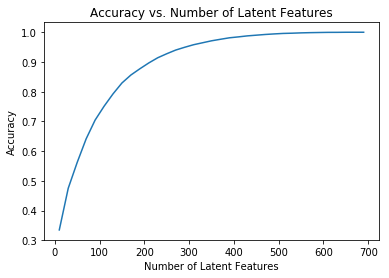

In [57]:
import numpy as np
import matplotlib.pyplot as plt

# Define range of latent features
num_latent_feats = np.arange(10, 700+10, 20)
sum_errs = []

# Loop through different latent feature sizes
for k in num_latent_feats:
    # Restructure with k latent features
    Sigma_new, U_new, Vt_new = np.diag(Sigma[:k]), U[:, :k], Vt[:k, :]
    
    # Take dot product to get the estimated user-item matrix
    user_item_est = np.around(np.dot(np.dot(U_new, Sigma_new), Vt_new))
    
    # Compute error for each prediction (actual vs predicted)
    diffs = np.subtract(user_item_matrix, user_item_est)
    
    # Sum errors and keep track of them
    err = np.sum(np.sum(np.abs(diffs)))
    sum_errs.append(err)

# Plot accuracy vs. number of latent features
plt.plot(num_latent_feats, 1 - np.array(sum_errs) / df.shape[0])
plt.xlabel('Number of Latent Features')
plt.ylabel('Accuracy')
plt.title('Accuracy vs. Number of Latent Features')
plt.show()


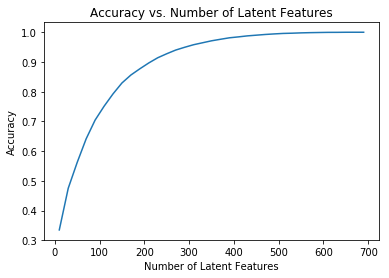

In [58]:
import numpy as np
import matplotlib.pyplot as plt

# Define range of latent features
num_latent_feats = np.arange(10, 700+10, 20)
sum_errs = []

# Loop through different latent feature sizes
for k in num_latent_feats:
    # Restructure with k latent features
    s_new, u_new, vt_new = np.diag(s[:k]), u[:, :k], vt[:k, :]
    
    # Take dot product to get the estimated user-item matrix
    user_item_est = np.around(np.dot(np.dot(u_new, s_new), vt_new))
    
    # Compute error for each prediction (actual vs predicted)
    diffs = np.subtract(user_item_matrix, user_item_est)
    
    # Sum errors and keep track of them
    err = np.sum(np.sum(np.abs(diffs)))
    sum_errs.append(err)

# Plot accuracy vs. number of latent features
plt.plot(num_latent_feats, 1 - np.array(sum_errs)/df.shape[0])
plt.xlabel('Number of Latent Features')
plt.ylabel('Accuracy')
plt.title('Accuracy vs. Number of Latent Features')
plt.show()


`4.` From the above, we can't really be sure how many features to use, because simply having a better way to predict the 1's and 0's of the matrix doesn't exactly give us an indication of if we are able to make good recommendations.  Instead, we might split our dataset into a training and test set of data, as shown in the cell below.  

Use the code from question 3 to understand the impact on accuracy of the training and test sets of data with different numbers of latent features. Using the split below: 

* How many users can we make predictions for in the test set?  
* How many users are we not able to make predictions for because of the cold start problem?
* How many articles can we make predictions for in the test set?  
* How many articles are we not able to make predictions for because of the cold start problem?

In [59]:
# Splitting the data into training and test sets
df_train = df.head(40000)
df_test = df.tail(5993)

def create_test_and_train_user_item(df_train, df_test):
    '''
    INPUT:
    df_train - training dataframe
    df_test - test dataframe
    
    OUTPUT:
    user_item_train - a user-item matrix of the training dataframe 
                      (unique users for each row and unique articles for each column)
    user_item_test - a user-item matrix of the testing dataframe 
                     (unique users for each row and unique articles for each column)
    test_idx - all of the test user ids
    test_arts - all of the test article ids
    '''
    
    # Create user-item matrices for the training and test data
    user_item_train = create_user_item_matrix(df_train)
    user_item_test = create_user_item_matrix(df_test)
    
    # Get the user IDs and article IDs for the test data
    test_idx = user_item_test.index.tolist()  # User IDs from test set
    test_arts = user_item_test.columns.tolist()  # Article IDs from test set

    return user_item_train, user_item_test, test_idx, test_arts

# Call the function to create the user-item matrices for train and test data
user_item_train, user_item_test, test_idx, test_arts = create_test_and_train_user_item(df_train, df_test)


In [60]:
user_item_train.head(5)

article_id,0.0,2.0,4.0,8.0,9.0,12.0,14.0,15.0,16.0,18.0,...,1434.0,1435.0,1436.0,1437.0,1439.0,1440.0,1441.0,1442.0,1443.0,1444.0
user_id,,,,,,,,,,,,,,,,,,,,,
1,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,1,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,1,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [61]:
print(user_item_train.shape)

(4487, 714)


In [62]:
print(user_item_test.shape)

(682, 574)


In [63]:
len(test_idx)

682

In [64]:
len(test_arts)

574

In [65]:
# Replace the values in the dictionary below
a = 662 
b = 574 
c = 20 
d = 0 

sol_4_dict = {
    'How many users can we make predictions for in the test set?': c,  # letter here
    'How many users in the test set are we not able to make predictions for because of the cold start problem?': a,  # letter here
    'How many articles can we make predictions for in the test set?': b,  # letter here
    'How many articles in the test set are we not able to make predictions for because of the cold start problem?': d  # letter here
}

t.sol_4_test(sol_4_dict)


Awesome job!  That's right!  All of the test articles are in the training data, but there are only 20 test users that were also in the training set.  All of the other users that are in the test set we have no data on.  Therefore, we cannot make predictions for these users using SVD.


`5.` Now use the **user_item_train** dataset from above to find U, S, and V transpose using SVD. Then find the subset of rows in the **user_item_test** dataset that you can predict using this matrix decomposition with different numbers of latent features to see how many features makes sense to keep based on the accuracy on the test data. This will require combining what was done in questions `2` - `4`.

Use the cells below to explore how well SVD works towards making predictions for recommendations on the test data.  

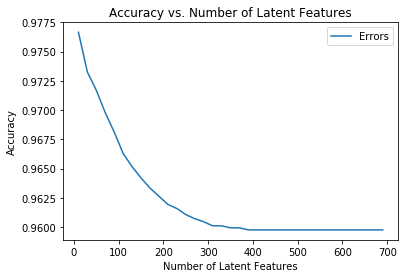

In [66]:
# Fit SVD on the user_item_train matrix
u_train, s_train, vt_train = np.linalg.svd(user_item_train)  # Perform SVD

# Check shapes of the SVD matrices
u_train.shape, s_train.shape, vt_train.shape  # Output shapes of u, s, and vt

# Getting the Rows for testing
test_idx = user_item_test.index  # User IDs in the test data

from sklearn.metrics import accuracy_score
num_latent_feats = np.arange(10, 700 + 10, 20)  # Latent feature sizes

sum_err = []  # List to store errors for each latent feature size

# Get rows and columns for testing
get_row = user_item_train.index.isin(test_idx)
utesting = u_train[get_row, :]  # Testing rows

# Getting the Columns
test_col = user_item_test.columns
get_column = user_item_train.columns.isin(test_col)
lvttesting = vt_train[:, get_column]  # Testing columns

# Subset of the test data for comparison
train_idx = user_item_train.index
get_row2 = user_item_test.index.isin(train_idx)
subset_test = user_item_test.loc[get_row2]  # Subset of test data

# Loop through different latent feature sizes
for k in num_latent_feats:
    # Restructure with k latent features
    s_new = np.diag(s_train[:k])  # Diagonal matrix for singular values
    u_new = u_train[:, :k]  # Select top k rows
    vt_new = vt_train[:k, :]  # Select top k columns
    
    # Create testing matrices for rows and columns
    utesting_k = utesting[:, :k]  # Ensure correct dimensionality for testing rows
    lvttesting_k = lvttesting[:k, :]  # Ensure correct dimensionality for testing columns
    
    # Take dot product to get the predictions
    train_prediction = np.around(np.dot(np.dot(u_new, s_new), vt_new))  # Training prediction
    test_prediction = np.around(np.dot(np.dot(utesting_k, s_new), lvttesting_k))  # Test prediction
    
    # Compute errors and keep track of them
    sum_err.append(1 - (np.sum(test_prediction) + np.sum(np.sum(subset_test))) / (subset_test.shape[0] * subset_test.shape[1]))

# Plot the errors vs. number of latent features
plt.figure()
plt.plot(num_latent_feats, sum_err, label='Errors')
plt.xlabel('Number of Latent Features')
plt.ylabel('Accuracy')
plt.title('Accuracy vs. Number of Latent Features')
plt.legend()
plt.show()


`6.` Use the cell below to comment on the results you found in the previous question. Given the circumstances of your results, discuss what you might do to determine if the recommendations you make with any of the above recommendation systems are an improvement to how users currently find articles? 

In the test data, accuracy decreases as the number of latent features increases. This could be due to the fact that only 20 users are shared between the test and training datasets. Additionally, there is an imbalance in user-article interactions, with most values being zero. While increasing the number of latent features in the training data improves accuracy, this does not hold for the test data, suggesting a potential overfitting issue. To address this, cross-validation could help identify the optimal number of latent features that generalize well across different subsets of the data.

**Improvement** - The high accuracy achieved with SVD indicates that it already provides an improvement over rank-based recommendation and collaborative filtering. To further evaluate the effectiveness of different recommendation systems, we could implement an A/B testing approach.

To conduct successful A/B testing, we should:

1. Ensure that each recommendation system receives an equal and random sample of users.
2. Test only one variable at a time—in this case, the recommendation systems themselves—without introducing other factors.
3. Allow the test to run long enough to collect sufficient data for meaningful statistical analysis.
4. Consider gathering user feedback through surveys or polls. While A/B testing is focused on quantitative data, qualitative insights can help explain why users make certain choices.

<a id='conclusions'></a>
### Extras
Using your workbook, you could now save your recommendations for each user, develop a class to make new predictions and update your results, and make a flask app to deploy your results.  These tasks are beyond what is required for this project.  However, from what you learned in the lessons, you certainly capable of taking these tasks on to improve upon your work here!


## Conclusion

> Congratulations!  You have reached the end of the Recommendations with IBM project! 

> **Tip**: Once you are satisfied with your work here, check over your report to make sure that it is satisfies all the areas of the [rubric](https://review.udacity.com/#!/rubrics/2322/view). You should also probably remove all of the "Tips" like this one so that the presentation is as polished as possible.


## Directions to Submit

> Before you submit your project, you need to create a .html or .pdf version of this notebook in the workspace here. To do that, run the code cell below. If it worked correctly, you should get a return code of 0, and you should see the generated .html file in the workspace directory (click on the orange Jupyter icon in the upper left).

> Alternatively, you can download this report as .html via the **File** > **Download as** submenu, and then manually upload it into the workspace directory by clicking on the orange Jupyter icon in the upper left, then using the Upload button.

> Once you've done this, you can submit your project by clicking on the "Submit Project" button in the lower right here. This will create and submit a zip file with this .ipynb doc and the .html or .pdf version you created. Congratulations! 

In [67]:
from subprocess import call
call(['python', '-m', 'nbconvert', 'Recommendations_with_IBM.ipynb'])

0